# 📊 Step 3 : Lexical Analysis

**Objectif**: Analyser les fréquences, co-occurrences et spécificités lexicales

**Analyses réalisées**:
1. Fréquences globales et par document
2. Co-occurrences autour des termes clés ("AI agent", "autonomy", etc.)
3. N-grams (bigrams et trigrams)
4. TF-IDF (termes distinctifs par rapport/institution)
5. Analyse comparative Consulting vs Academic vs Industry

**Output**: Visualisations et insights pour la section 3.1 du rapport

## 🔧 Setup Config & Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Imports
import json
import pickle
from pathlib import Path
from collections import Counter, defaultdict
from itertools import combinations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk import bigrams, trigrams
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.collocations import BigramAssocMeasures, TrigramAssocMeasures

# Lexical Analysis
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Progress bar
from tqdm.notebook import tqdm

# Viz Config
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

# Configuration pour de meilleurs graphiques
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("✅ Imports")

✅ Imports


## 📂 Load preprocessed corpus

In [2]:
# Paths
PROJECT_ROOT = Path.cwd().parent
PROCESSED_DATA = PROJECT_ROOT / "data" / "processed"
CORPUS_FILE = PROCESSED_DATA / "preprocessed_corpus.pkl"
METADATA_FILE = PROCESSED_DATA / "metadata" / "corpus_metadata.json"

# Create folder for analysis results
ANALYSIS_DIR = PROCESSED_DATA / "analysis"
ANALYSIS_DIR.mkdir(exist_ok=True)

print(f"📁 Analysis folder : {ANALYSIS_DIR}")

📁 Analysis folder : c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis


In [3]:
# Load preprocessed corpus
with open(CORPUS_FILE, 'rb') as f:
    processed_corpus = pickle.load(f)

# Load metadata
with open(METADATA_FILE, 'r', encoding='utf-8') as f:
    metadata = json.load(f)

print(f"✅ {len(processed_corpus)} documents loaded")

✅ 21 documents loaded


In [4]:
# Mapping doc_id -> source_type
doc_to_source = {doc_id: metadata[doc_id]['source_type'] 
                 for doc_id in processed_corpus.keys()}

print(f"\n📊 Type distribution:")
for source_type, count in Counter(doc_to_source.values()).items():
    print(f"  • {source_type:15} : {count} document(s)")


📊 Type distribution:
  • Consulting      : 7 document(s)
  • Industry        : 5 document(s)
  • Academic        : 4 document(s)
  • Policy          : 5 document(s)


## 📈 Global frequencies analysis

### Corpus frequencies

In [7]:
# Aggregate all tokens
all_tokens = []
for doc_data in processed_corpus.values():
    all_tokens.extend(doc_data['tokens'])

# Frequencies counter
global_freq = Counter(all_tokens)
vocab_size = len(global_freq)
total_tokens = len(all_tokens)

print(f"\nUnique vocabulary   : {vocab_size:,} words")
print(f"Tokens count        : {total_tokens:,}")


Unique vocabulary   : 25,136 words
Tokens count        : 291,839


In [8]:
print("TOP 50 MOST FREQUENT WORDS")
top_50 = global_freq.most_common(50)
for i, (word, count) in enumerate(top_50, 1):
    freq_pct = (count / total_tokens) * 100
    print(f"{i:2}. {word:20} : {count:5,} ({freq_pct:5.2f}%)")

TOP 50 MOST FREQUENT WORDS
 1. cid                  : 16,851 ( 5.77%)
 2. -                    : 6,670 ( 2.29%)
 3. human                : 2,193 ( 0.75%)
 4. model                : 2,052 ( 0.70%)
 5. agent                : 1,947 ( 0.67%)
 6. system               : 1,674 ( 0.57%)
 7. datum                : 1,382 ( 0.47%)
 8. agentic              : 1,322 ( 0.45%)
 9. development          : 1,280 ( 0.44%)
10. other                : 1,271 ( 0.44%)
11. index                : 1,265 ( 0.43%)
12. intelligence         : 1,259 ( 0.43%)
13. artificial           : 1,121 ( 0.38%)
14. technology           : 1,045 ( 0.36%)
15. task                 :   923 ( 0.32%)
16. new                  :   859 ( 0.29%)
17. use                  :   851 ( 0.29%)
18. source               :   850 ( 0.29%)
19. people               :   774 ( 0.27%)
20. country              :   754 ( 0.26%)
21. base                 :   724 ( 0.25%)
22. across               :   724 ( 0.25%)
23. work                 :   723 ( 0.25%)
24. hi

### Global frequencies visualization

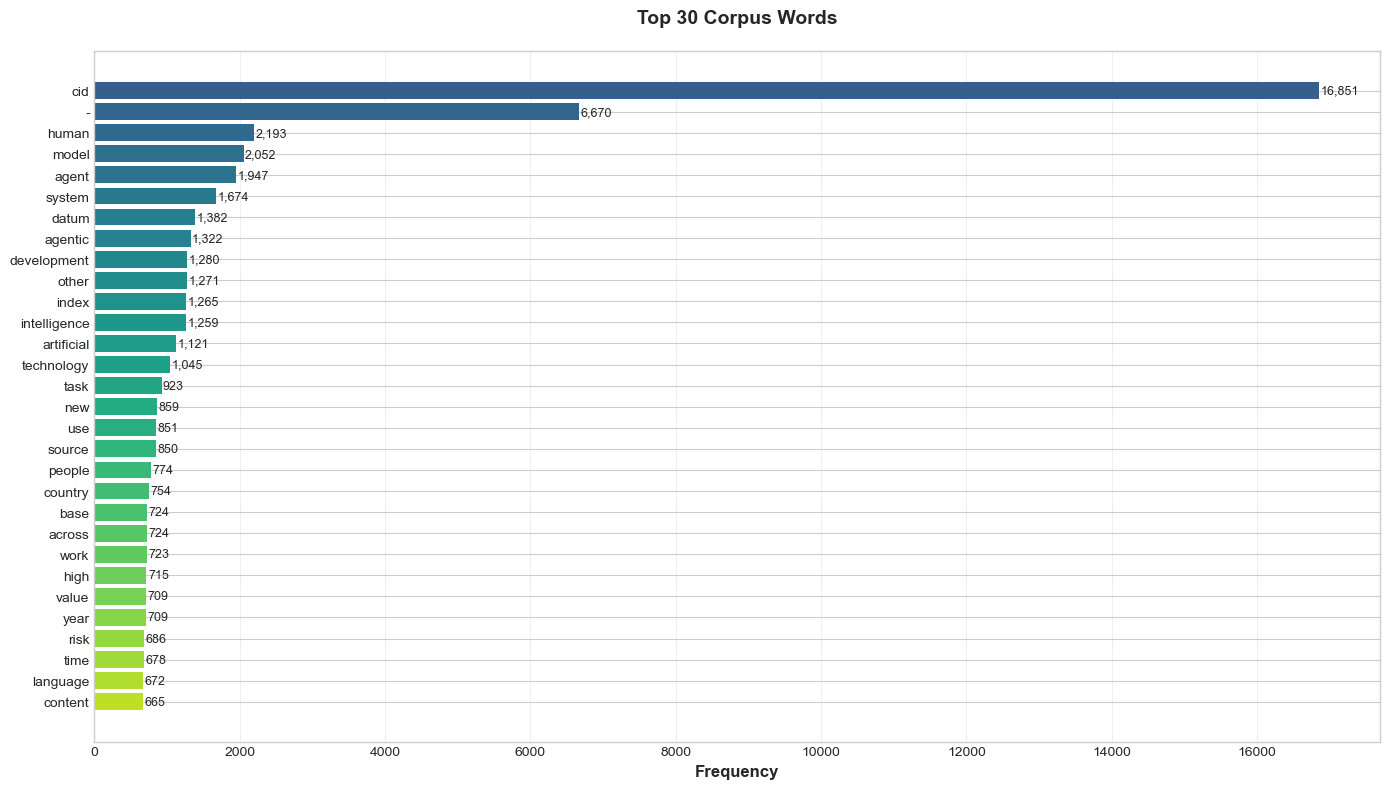

💾 Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\top30_global_frequencies.png


In [9]:
# Top 30
top_30_words = [word for word, _ in global_freq.most_common(30)]
top_30_counts = [count for _, count in global_freq.most_common(30)]

# Viz plot
fig, ax = plt.subplots(figsize=(14, 8))

colors = plt.cm.viridis(np.linspace(0.3, 0.9, 30))
bars = ax.barh(range(30), top_30_counts, color=colors)

ax.set_yticks(range(30))
ax.set_yticklabels(top_30_words)
ax.invert_yaxis()
ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Top 30 Corpus Words', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

# Add values on bar
for i, (bar, count) in enumerate(zip(bars, top_30_counts)):
    ax.text(count + 20, i, f'{count:,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'top30_global_frequencies.png', bbox_inches='tight')
plt.show()

print(f"💾 Graph saved to: {ANALYSIS_DIR / 'top30_global_frequencies.png'}")

### Refine global corpus WordCloud

In [10]:
# Optimize parameters
wordcloud = WordCloud(
    width=2000, 
    height=1000,
    background_color='white',
    colormap='RdYlBu_r',
    max_words=150,
    relative_scaling=0.5,
    min_font_size=12,
    collocations=False  # Avoid repetitions
).generate_from_frequencies(global_freq)

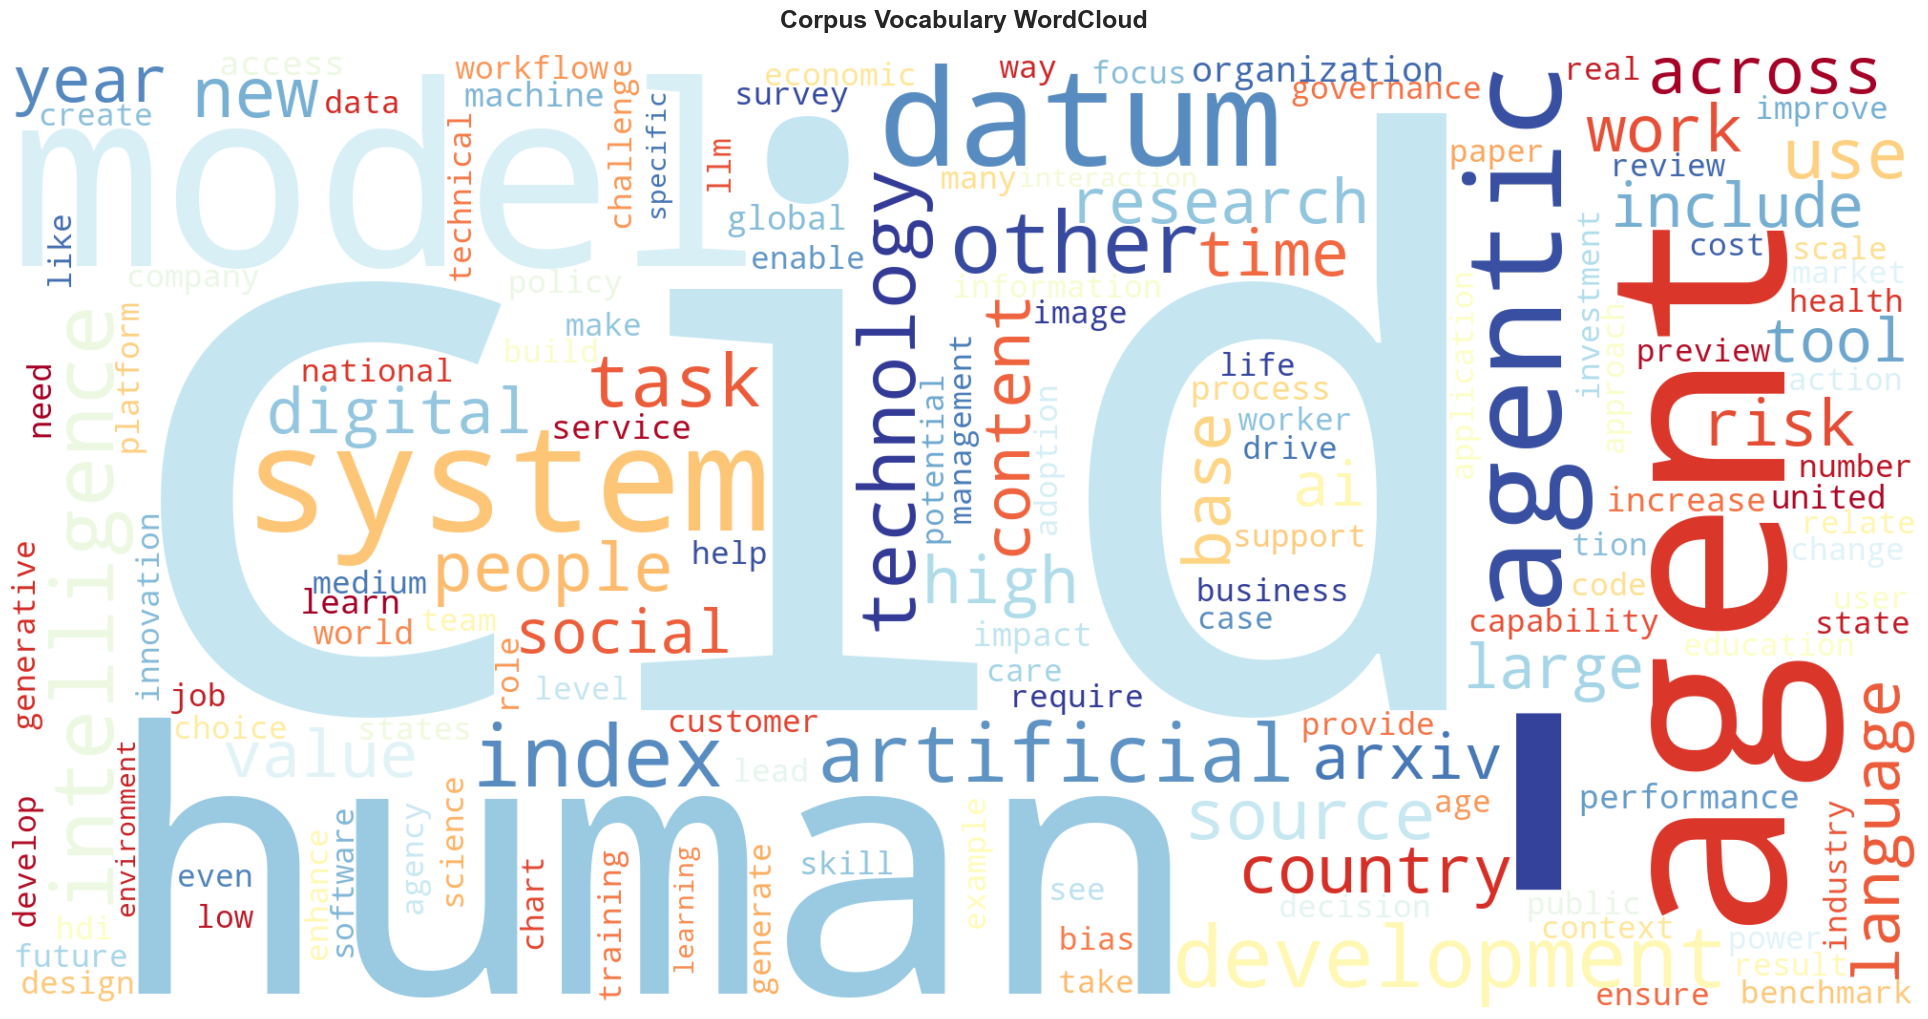

💾 WordCloud saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\wordcloud_global.png


In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
ax.set_title('Corpus Vocabulary WordCloud', 
             fontsize=18, fontweight='bold', pad=20)

plt.tight_layout(pad=0)
plt.savefig(ANALYSIS_DIR / 'wordcloud_global.png', bbox_inches='tight')
plt.show()

print(f"💾 WordCloud saved to: {ANALYSIS_DIR / 'wordcloud_global.png'}")

## 📊 Document-level analysis

### Document-level frequencies

In [12]:
# Count frequencies for each doc
doc_frequencies = {}
for doc_id, doc_data in processed_corpus.items():
    doc_frequencies[doc_id] = Counter(doc_data['tokens'])

In [13]:
for doc_id in list(processed_corpus.keys())[:3]:  # Show first 3 docs top 10 freq
    filename = metadata[doc_id]['filename']
    source_type = doc_to_source[doc_id]
    
    print(f"📄 {filename} ({source_type})")
    
    top_10 = doc_frequencies[doc_id].most_common(10)
    for i, (word, count) in enumerate(top_10, 1):
        print(f"  {i:2}. {word:20} : {count:4,}")

print(f"\n... (see CSV for all documents)")

📄 Bain_report_technology_report_2025.pdf (Consulting)
   1. -                    :  368
   2. technology           :  113
   3. company              :  108
   4. datum                :   89
   5. agent                :   88
   6. value                :   77
   7. tech                 :   72
   8. quantum              :   71
   9. year                 :   70
  10. software             :   66
📄 BCG_AI_Agents_2025.pdf (Consulting)
   1. agent                :   82
   2. -                    :   17
   3. human                :   16
   4. task                 :   12
   5. use                  :   12
   6. plan                 :   11
   7. business             :   10
   8. process              :    9
   9. datum                :    9
  10. environment          :    9
📄 Deloitte_The_business_imperative_for_Agentic_AI_2025.pdf (Consulting)
   1. cid                  : 16,850
   2. agentic              :  107
   3. agent                :   65
   4. business             :   42
   5. imperative  

### Top words per document

In [14]:
# Create DataFrame for viz
top_n = 15

# Extract top 15 /doc
data_for_viz = []
for doc_id, freq_counter in doc_frequencies.items():
    top_words = freq_counter.most_common(top_n)
    filename_short = metadata[doc_id]['filename'][:25]
    
    for word, count in top_words:
        data_for_viz.append({
            'document': filename_short,
            'word': word,
            'count': count,
            'source_type': doc_to_source[doc_id]
        })

df_top_words = pd.DataFrame(data_for_viz)
df_top_words.head()

document        word  count source_type
0  Bain_report_technology_re           -    368  Consulting
1  Bain_report_technology_re  technology    113  Consulting
2  Bain_report_technology_re     company    108  Consulting
3  Bain_report_technology_re       datum     89  Consulting
4  Bain_report_technology_re       agent     88  Consulting

In [15]:
# Create most frequent words heatmap
# Take the 20 most frequent global words
top_global_words = [w for w, _ in global_freq.most_common(20)]

# Create document x word matrix
heatmap_data = []
doc_labels = []

for doc_id in processed_corpus.keys():
    filename_short = metadata[doc_id]['filename'][:30]
    doc_labels.append(filename_short)
    
    row = []
    for word in top_global_words:
        row.append(doc_frequencies[doc_id].get(word, 0))
    heatmap_data.append(row)

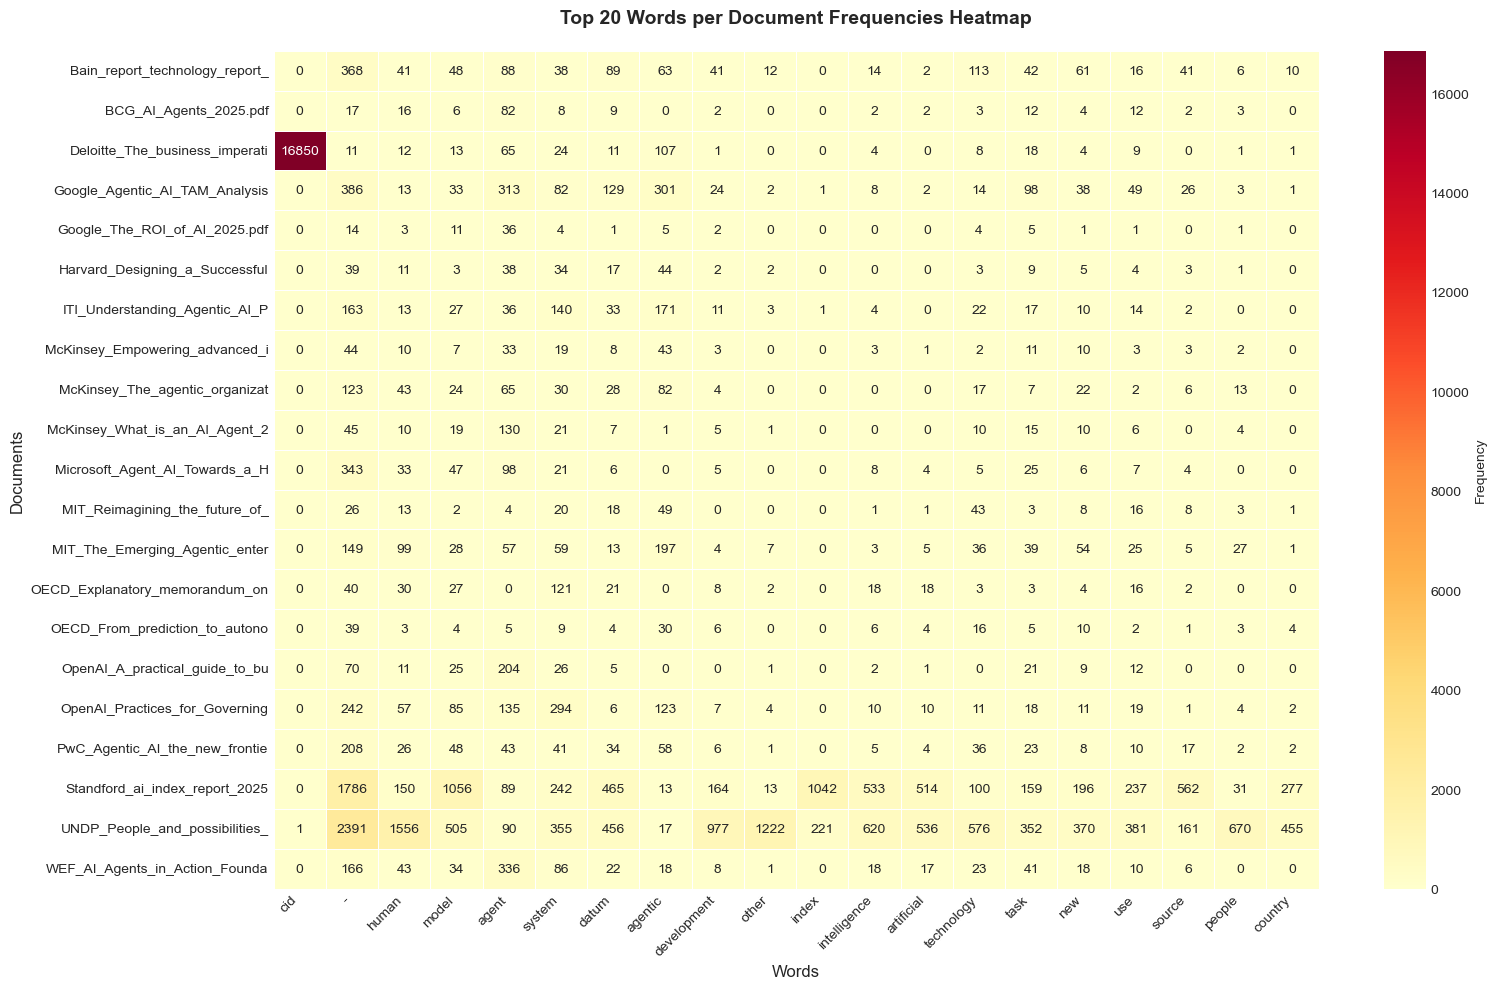

💾 Heatmap saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\heatmap_top_words_by_doc.png


In [16]:
# Plot
fig, ax = plt.subplots(figsize=(16, 10))

heatmap_df = pd.DataFrame(heatmap_data, index=doc_labels, columns=top_global_words)
sns.heatmap(heatmap_df, annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Frequency'}, ax=ax)

ax.set_title('Top 20 Words per Document Frequencies Heatmap', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Words', fontsize=12)
ax.set_ylabel('Documents', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'heatmap_top_words_by_doc.png', bbox_inches='tight')
plt.show()

print(f"💾 Heatmap saved to: {ANALYSIS_DIR / 'heatmap_top_words_by_doc.png'}")

## 🎯 Key words specific to domain

### Agentic AI key words frequency

In [17]:
# Define domain key words
KEY_TERMS = {
    'Core Concepts': ['agent', 'agentic', 'autonomy', 'autonomous', 'intelligence'],
    'Implementation': ['system', 'model', 'architecture', 'framework', 'platform'],
    'Business Value': ['productivity', 'efficiency', 'automation', 'optimization', 'roi'],
    'Workforce': ['workforce', 'employee', 'worker', 'human', 'job', 'skill'],
    'Technology': ['data', 'algorithm', 'learning', 'machine', 'generative'],
    'Governance': ['governance', 'risk', 'compliance', 'regulation', 'ethics', 'trust'],
    'Operations': ['workflow', 'orchestration', 'process', 'task', 'operation'],
    'Assistance': ['copilot', 'assistant', 'support', 'augmentation', 'collaboration']
}

In [18]:
# Counts by each category
category_counts = defaultdict(int)
for category, terms in KEY_TERMS.items():
    for term in terms:
        category_counts[category] += global_freq.get(term, 0)

print("\nOccurrences by category:")
for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{category:20} : {count:5,} occurrences")


Occurrences by category:
Core Concepts        : 4,829 occurrences
Implementation       : 4,389 occurrences
Workforce            : 3,460 occurrences
Operations           : 2,023 occurrences
Technology           : 1,697 occurrences
Governance           : 1,508 occurrences
Business Value       :   699 occurrences
Assistance           :   688 occurrences


In [19]:
# Details by key terms
print("DETAILS BY KEY TERMS")
key_term_details = []
for category, terms in KEY_TERMS.items():
    print(f"\n{category}:")
    for term in terms:
        count = global_freq.get(term, 0)
        print(f"  • {term:20} : {count:4,}")
        key_term_details.append({
            'category': category,
            'term': term,
            'count': count
        })

df_key_terms = pd.DataFrame(key_term_details)
df_key_terms.head()

DETAILS BY KEY TERMS

Core Concepts:
  • agent                : 1,947
  • agentic              : 1,322
  • autonomy             :  137
  • autonomous           :  164
  • intelligence         : 1,259

Implementation:
  • system               : 1,674
  • model                : 2,052
  • architecture         :  106
  • framework            :  235
  • platform             :  322

Business Value:
  • productivity         :  225
  • efficiency           :  165
  • automation           :  221
  • optimization         :   51
  • roi                  :   37

Workforce:
  • workforce            :  113
  • employee             :  145
  • worker               :  321
  • human                : 2,193
  • job                  :  333
  • skill                :  355

Technology:
  • data                 :  392
  • algorithm            :  158
  • learning             :  260
  • machine              :  532
  • generative           :  355

Governance:
  • governance           :  366
  • risk             

category          term  count
0  Core Concepts         agent   1947
1  Core Concepts       agentic   1322
2  Core Concepts      autonomy    137
3  Core Concepts    autonomous    164
4  Core Concepts  intelligence   1259

### Key term visualization by categories

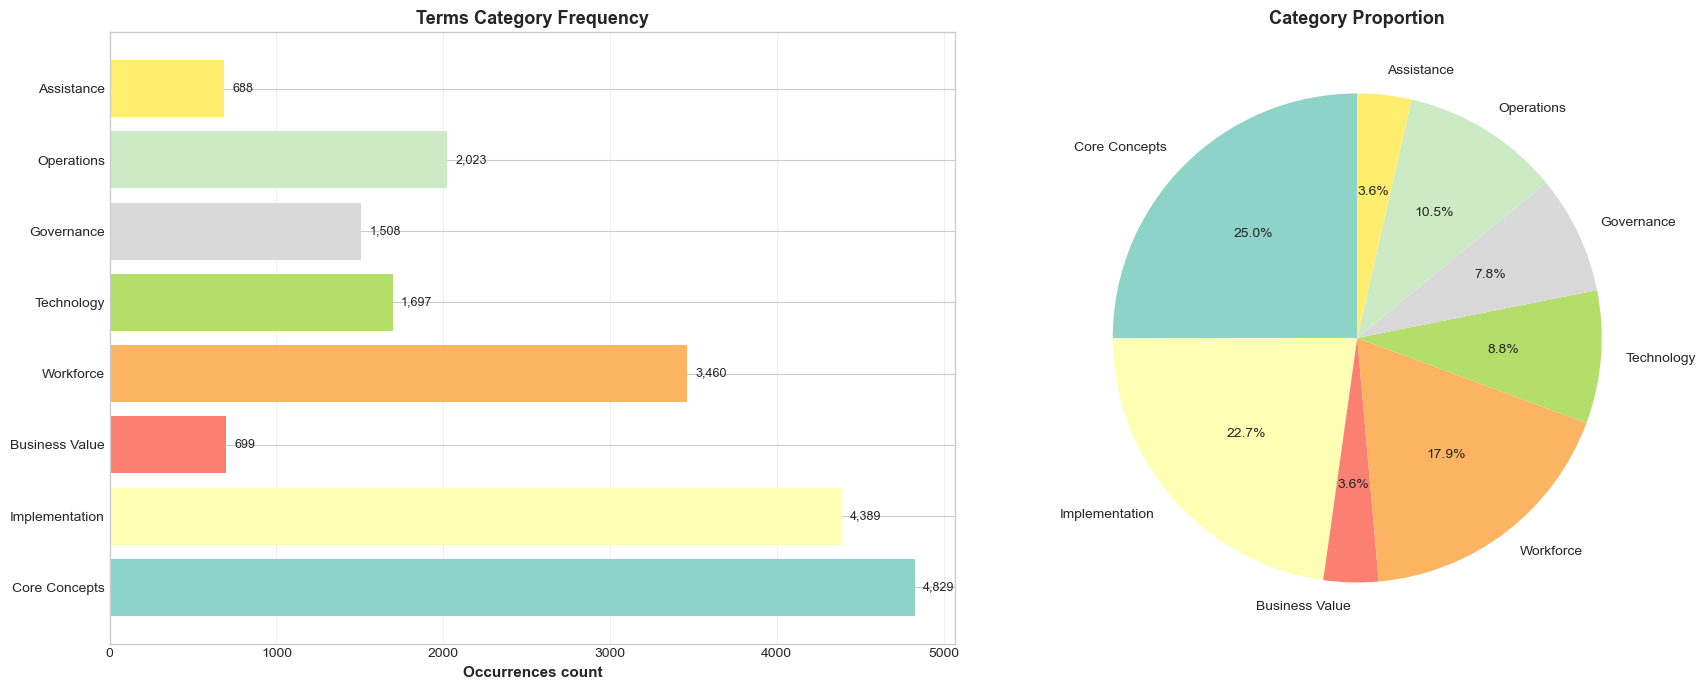

💾 Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\key_terms_categories.png


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Horizontal bar chart
categories = list(category_counts.keys())
counts = list(category_counts.values())
colors_cat = plt.cm.Set3(np.linspace(0, 1, len(categories)))

axes[0].barh(categories, counts, color=colors_cat)
axes[0].set_xlabel('Occurrences count', fontsize=11, fontweight='bold')
axes[0].set_title('Terms Category Frequency', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

for i, (cat, count) in enumerate(zip(categories, counts)):
    axes[0].text(count + 50, i, f'{count:,}', va='center', fontsize=9)

# Pie chart
axes[1].pie(counts, labels=categories, autopct='%1.1f%%', startangle=90,
           colors=colors_cat)
axes[1].set_title('Category Proportion', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'key_terms_categories.png', bbox_inches='tight')
plt.show()

print(f"💾 Graph saved to: {ANALYSIS_DIR / 'key_terms_categories.png'}")

### Top Termes by category

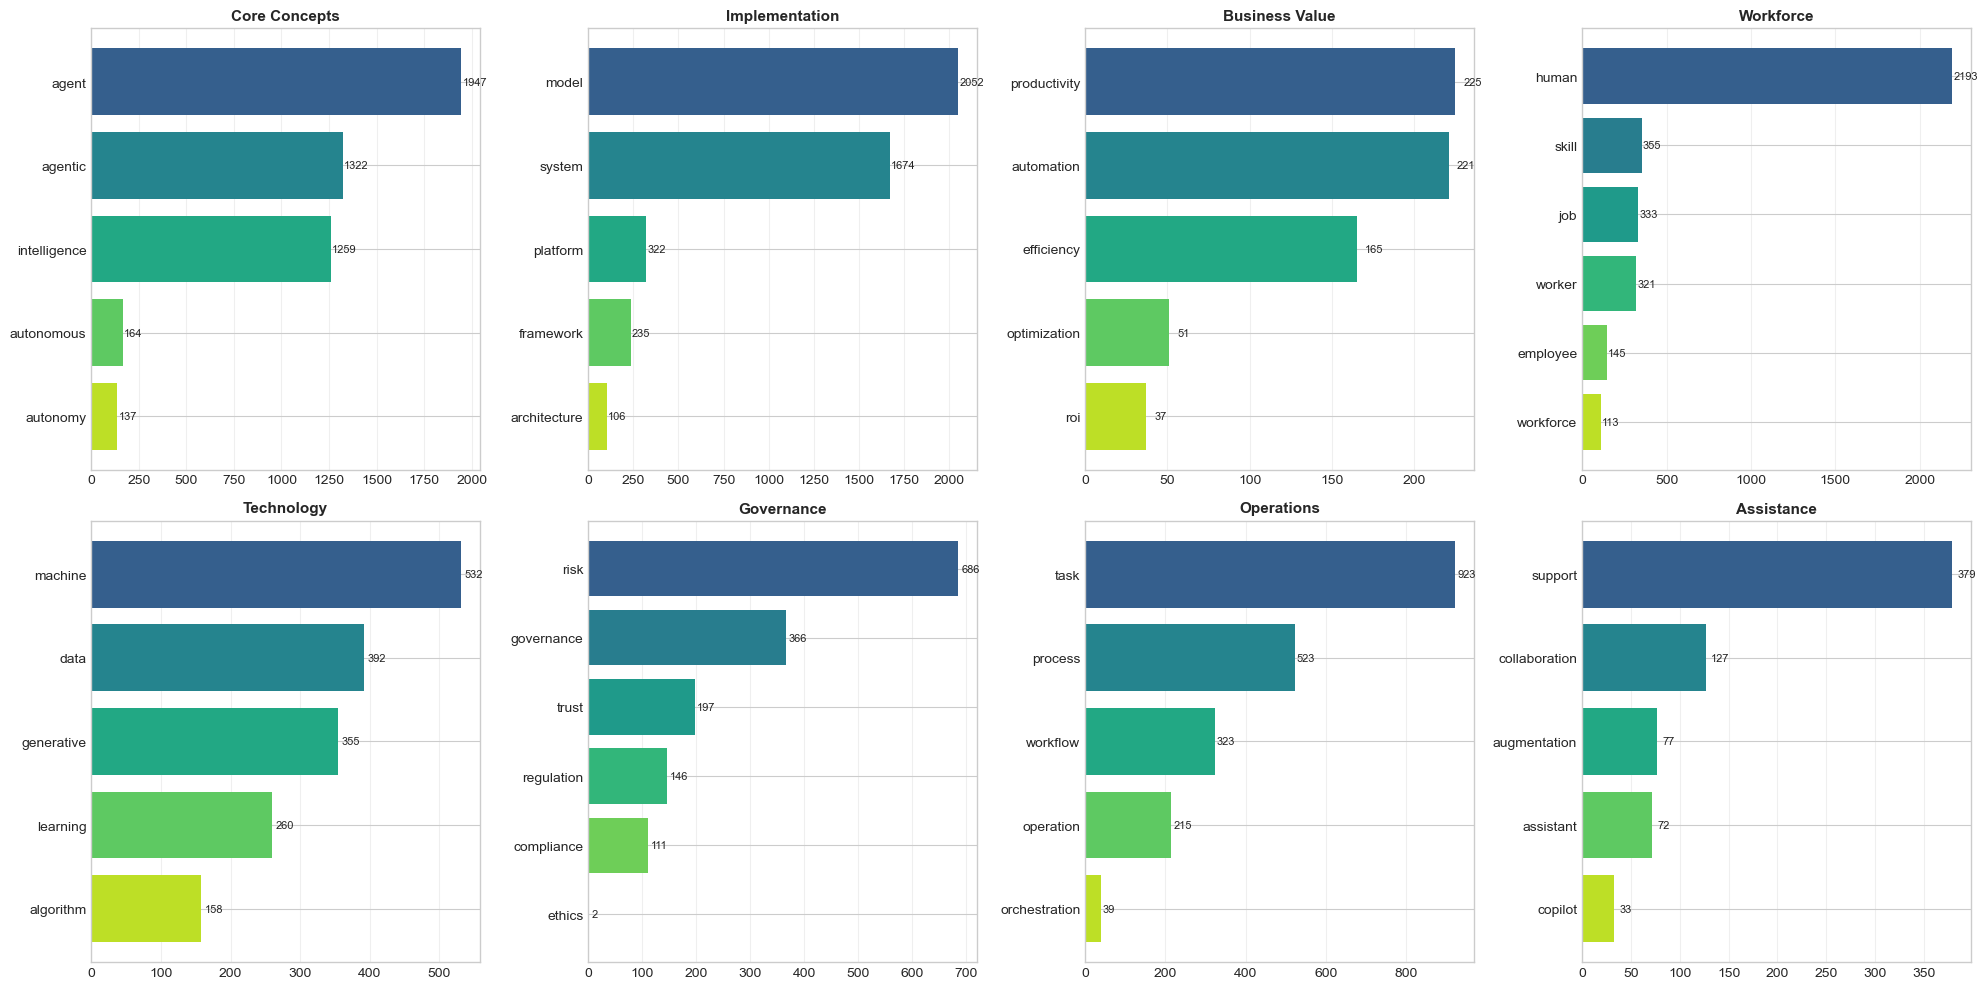

💾 Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\key_terms_detailed.png


In [21]:
n_categories = len(KEY_TERMS)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (category, terms) in enumerate(KEY_TERMS.items()):
    # Term frequency
    term_counts = [(term, global_freq.get(term, 0)) for term in terms]
    term_counts.sort(key=lambda x: x[1], reverse=True)
    
    words = [t[0] for t in term_counts]
    counts = [t[1] for t in term_counts]
    
    # Plotting
    ax = axes[idx]
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(words)))
    ax.barh(words, counts, color=colors)
    ax.set_title(category, fontsize=11, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    for i, (word, count) in enumerate(zip(words, counts)):
        if count > 0:
            ax.text(count + 5, i, str(count), va='center', fontsize=8)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'key_terms_detailed.png', bbox_inches='tight')
plt.show()

print(f"💾 Graph saved to: {ANALYSIS_DIR / 'key_terms_detailed.png'}")

## 🔗 Co-occurrences surrounding key terms

### Co-occurrences with "agent" / "agentic"

In [22]:
def find_cooccurrences(tokens, target_word, window=5):
    """
    Trouve les mots qui co-occurrent avec un mot cible dans une fenêtre donnée.
    
    Args:
        tokens: Liste de tokens
        target_word: Mot cible
        window: Taille de la fenêtre (mots avant et après)
    
    Returns:
        Counter des co-occurrences
    """
    cooccur = Counter()
    
    for i, token in enumerate(tokens):
        if token == target_word:
            # Fenêtre avant
            start = max(0, i - window)
            # Fenêtre après
            end = min(len(tokens), i + window + 1)
            
            # Ajouter tous les mots dans la fenêtre (sauf le mot cible)
            for j in range(start, end):
                if j != i:
                    cooccur[tokens[j]] += 1
    
    return cooccur

In [23]:
# Analyze co-occurrences for central terms
TARGET_WORDS = ['agent', 'agentic', 'autonomy', 'autonomous', 'ai']

cooccurrence_results = {}

for target in TARGET_WORDS:
    print(f"Co-occurrences with '{target}' (±5 words)")
    
    cooccur = find_cooccurrences(all_tokens, target, window=5)
    cooccurrence_results[target] = cooccur
    
    # Top 20
    top_20 = cooccur.most_common(20)
    for i, (word, count) in enumerate(top_20, 1):
        print(f"  {i:2}. {word:20} : {count:4,}")

Co-occurrences with 'agent' (±5 words)
   1. agent                :  954
   2. -                    :  522
   3. system               :  265
   4. human                :  145
   5. cid                  :  134
   6. task                 :  121
   7. workflow             :  116
   8. action               :  111
   9. tool                 :  108
  10. governance           :  102
  11. user                 :   99
  12. agentic              :   95
  13. evaluation           :   92
  14. model                :   89
  15. customer             :   87
  16. foundation           :   86
  17. risk                 :   81
  18. organization         :   80
  19. use                  :   80
  20. across               :   77
Co-occurrences with 'agentic' (±5 words)
   1. system               :  405
   2. agentic              :  360
   3. cid                  :  264
   4. -                    :  218
   5. adoption             :  161
   6. organization         :  104
   7. value                :  101
  

### Co-occurrences visualization

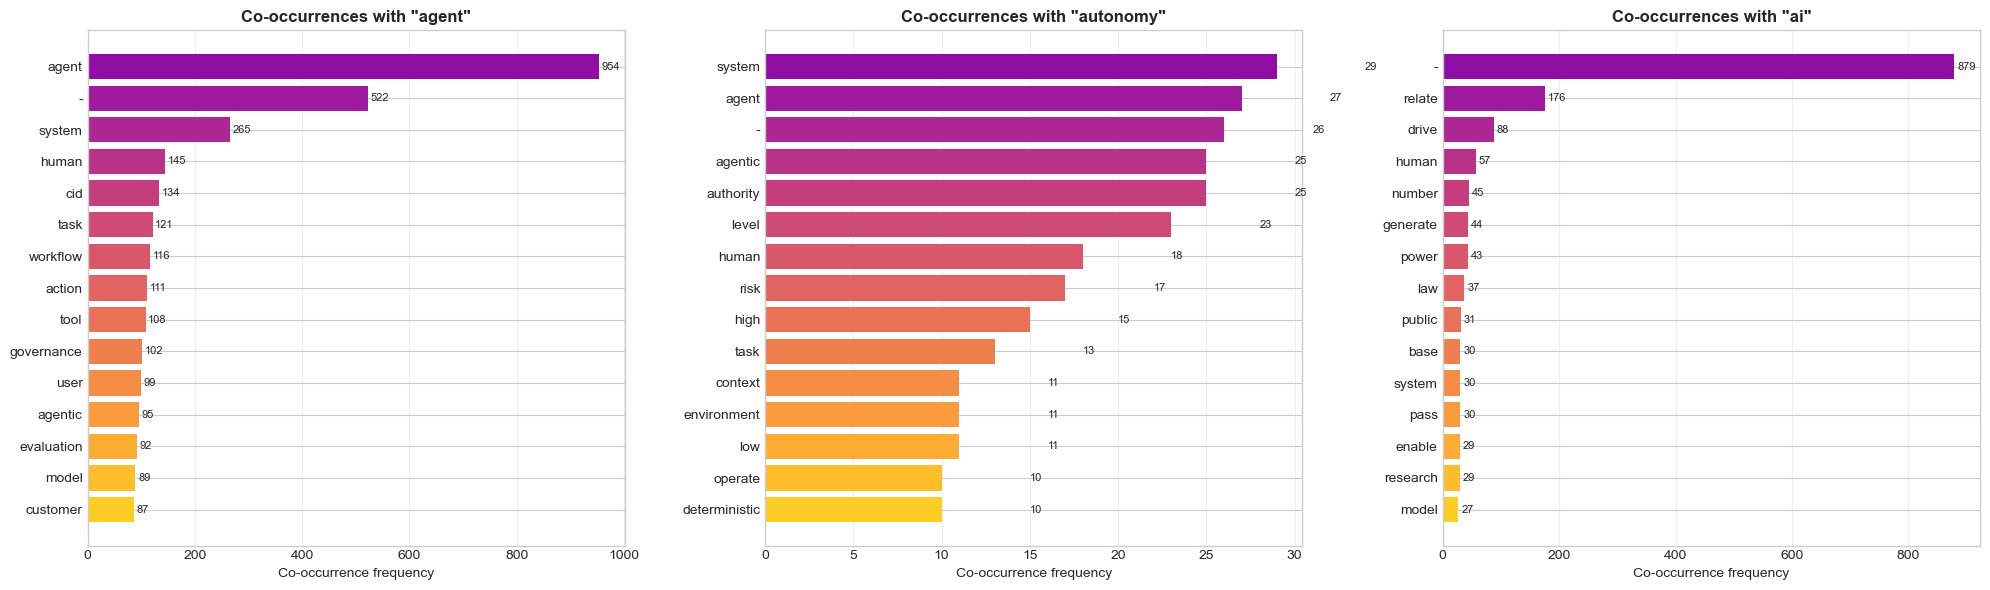

💾 Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\cooccurrences_main_terms.png


In [24]:
# Create graph for co-occurrences of the 3 main terms
main_targets = ['agent', 'autonomy', 'ai']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, target in enumerate(main_targets):
    cooccur = cooccurrence_results[target]
    top_15 = cooccur.most_common(15)
    
    words = [w for w, _ in top_15]
    counts = [c for _, c in top_15]
    
    ax = axes[idx]
    colors = plt.cm.plasma(np.linspace(0.3, 0.9, 15))
    ax.barh(range(15), counts, color=colors)
    ax.set_yticks(range(15))
    ax.set_yticklabels(words)
    ax.invert_yaxis()
    ax.set_xlabel('Co-occurrence frequency', fontsize=10)
    ax.set_title(f'Co-occurrences with "{target}"', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    for i, count in enumerate(counts):
        ax.text(count + 5, i, str(count), va='center', fontsize=8)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'cooccurrences_main_terms.png', bbox_inches='tight')
plt.show()

print(f"💾 Graph saved to: {ANALYSIS_DIR / 'cooccurrences_main_terms.png'}")

## 🔤 N-grams (Bigrams and Trigrams) 

### Bigrams extraction (2-grams)

In [25]:
# Generate bigrams
bigram_list = list(bigrams(all_tokens))
bigram_freq = Counter(bigram_list)

print(f"\nBigrams count: {len(bigram_freq):,}")


Bigrams count: 190,817


In [26]:
print("TOP 30 BIGRAMS")
top_30_bigrams = bigram_freq.most_common(30)
for i, (bigram, count) in enumerate(top_30_bigrams, 1):
    bigram_str = ' '.join(bigram)
    print(f"{i:2}. {bigram_str:35} : {count:4,}")

TOP 30 BIGRAMS
 1. cid cid                             : 16,611
 2. artificial intelligence             :  975
 3. human development                   :  617
 4. ai -                                :  570
 5. intelligence index                  :  434
 6. content preview                     :  368
 7. language model                      :  327
 8. chart index                         :  299
 9. agentic system                      :  258
10. large language                      :  254
11. united states                       :  243
12. high -                              :  218
13. - base                              :  210
14. - relate                            :  182
15. arxiv preprint                      :  175
16. human -                             :  161
17. to -                                :  159
18. preprint arxiv                      :  157
19. preview artificial                  :  157
20. - drive                             :  155
21. - to                                :  

### Bigrams with collocation measures (PMI)

In [27]:
# Use NLTK to identify significative collocations
bigram_finder = BigramCollocationFinder.from_words(all_tokens)

# Filter bigrams which appear at least 5 times
bigram_finder.apply_freq_filter(5)

# Bigrams w/ PMI (Pointwise Mutual Information)
bigram_measures = BigramAssocMeasures()
top_bigrams_pmi = bigram_finder.nbest(bigram_measures.pmi, 30)

print("TOP 30 BIGRAMS MEASURES (PMI)")
for i, bigram in enumerate(top_bigrams_pmi, 1):
    bigram_str = ' '.join(bigram)
    count = bigram_freq[bigram]
    print(f"{i:2}. {bigram_str:35} : {count:4,} occurrences")

TOP 30 BIGRAMS MEASURES (PMI)
 1. acir atsoc                          :    5 occurrences
 2. atsushi kanehira                    :    5 occurrences
 3. dhar thuppilikkat                   :    5 occurrences
 4. lari hämäläinen                     :    5 occurrences
 5. njenga kariuki                      :    5 occurrences
 6. peripheral arterial                 :    5 occurrences
 7. ruppanner churchill                 :    5 occurrences
 8. stobor lairtsudni                   :    5 occurrences
 9. abu dhabi                           :    6 occurrences
10. acirfa htuos                        :    6 occurrences
11. eisfeldt schubert                   :    5 occurrences
12. fuet ufureture                      :    6 occurrences
13. gnidnep cilbup                      :    6 occurrences
14. gnok gnoh                           :    6 occurrences
15. grigolia machaidze                  :    6 occurrences
16. hanushek woessmann                  :    5 occurrences
17. hector rivoire        

### Bigrams visualization

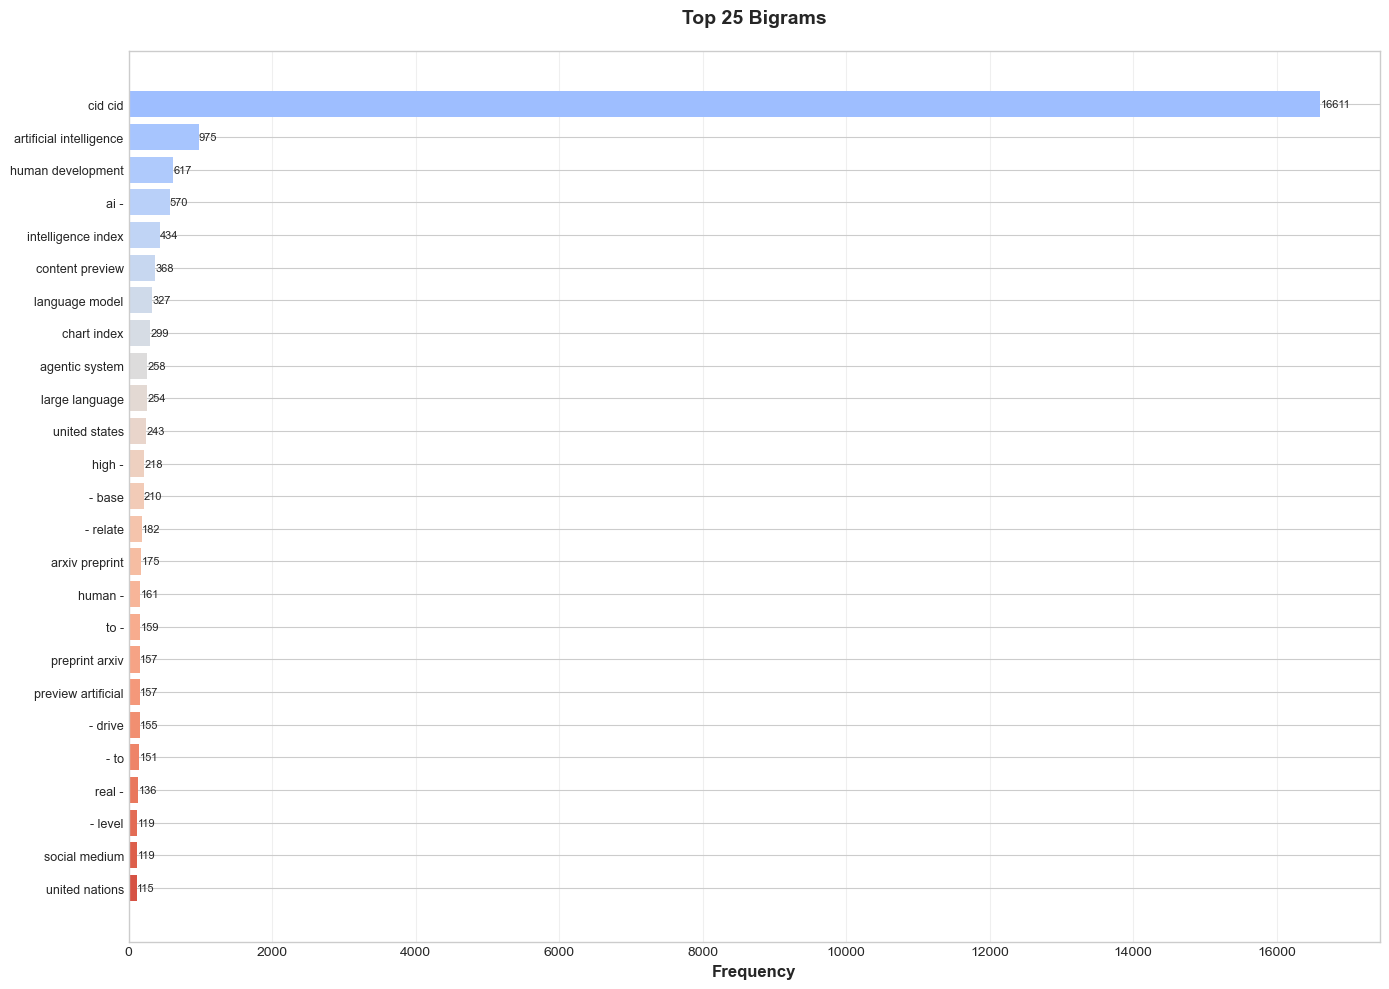

💾 Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\top25_bigrams.png


In [28]:
# Top 25 bigrams for viz
top_25_bigrams = bigram_freq.most_common(25)
bigram_labels = [' '.join(bg) for bg, _ in top_25_bigrams]
bigram_counts = [count for _, count in top_25_bigrams]

fig, ax = plt.subplots(figsize=(14, 10))

colors = plt.cm.coolwarm(np.linspace(0.3, 0.9, 25))
bars = ax.barh(range(25), bigram_counts, color=colors)

ax.set_yticks(range(25))
ax.set_yticklabels(bigram_labels, fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Top 25 Bigrams', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

for i, count in enumerate(bigram_counts):
    ax.text(count + 5, i, str(count), va='center', fontsize=8)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'top25_bigrams.png', bbox_inches='tight')
plt.show()

print(f"💾 Graph saved to: {ANALYSIS_DIR / 'top25_bigrams.png'}")

### Trigrams extraction (3-grams)

In [29]:
# Generate trigrams
trigram_list = list(trigrams(all_tokens))
trigram_freq = Counter(trigram_list)

print(f"\nTrigrams count: {len(trigram_freq):,}")


Trigrams count: 245,256


In [30]:
print("TOP 30 TRIGRAMS")
top_30_trigrams = trigram_freq.most_common(30)
for i, (trigram, count) in enumerate(top_30_trigrams, 1):
    trigram_str = ' '.join(trigram)
    print(f"{i:2}. {trigram_str:40} : {count:4,}")

TOP 30 TRIGRAMS
 1. cid cid cid                              : 16,372
 2. artificial intelligence index            :  434
 3. large language model                     :  217
 4. ai - relate                              :  161
 5. preview artificial intelligence          :  157
 6. content preview artificial               :  153
 7. - to -                                   :  146
 8. arxiv preprint arxiv                     :  141
 9. - the -                                  :  100
10. index artificial intelligence            :   91
11. chart index artificial                   :   88
12. - of -                                   :   84
13. decision - make                          :   84
14. ai - drive                               :   83
15. human development index                  :   71
16. real - time                              :   69
17. index technical performance              :   69
18. intelligence index technical             :   68
19. real - world                             :

### Trigrams visualization

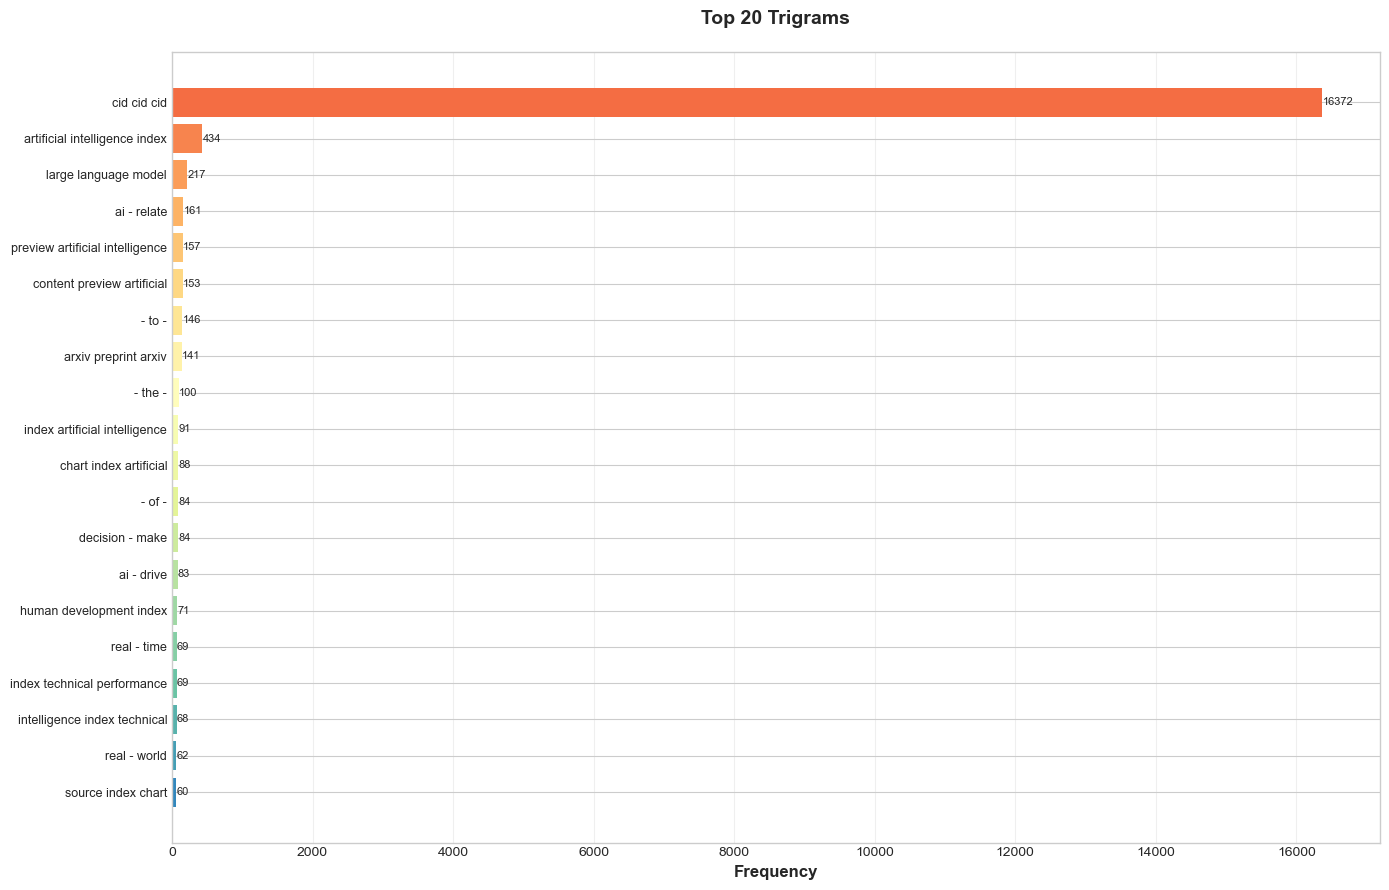

💾 Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\top20_trigrams.png


In [31]:
# Top 20 trigrams
top_20_trigrams = trigram_freq.most_common(20)
trigram_labels = [' '.join(tg) for tg, _ in top_20_trigrams]
trigram_counts = [count for _, count in top_20_trigrams]

fig, ax = plt.subplots(figsize=(14, 9))

colors = plt.cm.Spectral(np.linspace(0.2, 0.9, 20))
bars = ax.barh(range(20), trigram_counts, color=colors)

ax.set_yticks(range(20))
ax.set_yticklabels(trigram_labels, fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Trigrams', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

for i, count in enumerate(trigram_counts):
    ax.text(count + 2, i, str(count), va='center', fontsize=8)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'top20_trigrams.png', bbox_inches='tight')
plt.show()

print(f"💾 Graph saved to: {ANALYSIS_DIR / 'top20_trigrams.png'}")

## 🎯 TF-IDF for distinct terms per document

### Compute TF-IDF

In [32]:
# TF-IDF document preparation (join tokens in single text)
documents_for_tfidf = []
doc_ids_ordered = []

for doc_id, doc_data in processed_corpus.items():
    documents_for_tfidf.append(' '.join(doc_data['tokens']))
    doc_ids_ordered.append(doc_id)

# TF-IDF computation using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=500,  # Top 500 terms
    min_df=1,          # Min 1 doc
    max_df=0.95,       # Max 95% of docs
    ngram_range=(1, 1) # Unigrams only
)

tfidf_matrix = tfidf_vectorizer.fit_transform(documents_for_tfidf)
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"\n✅ TF-IDF matrix: {tfidf_matrix.shape}")
print(f"   {tfidf_matrix.shape[0]} documents × {tfidf_matrix.shape[1]} terms")


✅ TF-IDF matrix: (21, 500)
   21 documents × 500 terms


### Top TF-IDF terms by document

In [33]:
print("TOP 15 TERMES TF-IDF PAR DOCUMENT")

# Convert to DataFrame for easier analysis
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=doc_ids_ordered,
    columns=feature_names
)

# Extract top terms for each doc
top_terms_per_doc = {}
for doc_id in doc_ids_ordered:
    # TF-IDF score for doc
    doc_scores = tfidf_df.loc[doc_id].sort_values(ascending=False)
    top_15 = doc_scores.head(15)
    
    top_terms_per_doc[doc_id] = top_15.to_dict()
    
    if list(doc_ids_ordered).index(doc_id) < 3: # first 3
        filename = metadata[doc_id]['filename']
        source_type = doc_to_source[doc_id]
        
        print(f"\n📄 {filename} ({source_type})")
        
        for i, (term, score) in enumerate(top_15.items(), 1):
            print(f"   {i:2}. {term:25} : {score:.4f}")

print(f"\n... (see CSV for all docs)")

TOP 15 TERMES TF-IDF PAR DOCUMENT

📄 Bain_report_technology_report_2025.pdf (Consulting)
    1. company                   : 0.2738
    2. tech                      : 0.2556
    3. year                      : 0.1885
    4. software                  : 0.1835
    5. workflow                  : 0.1696
    6. agentic                   : 0.1672
    7. market                    : 0.1529
    8. see                       : 0.1445
    9. leader                    : 0.1370
   10. computing                 : 0.1334
   11. billion                   : 0.1290
   12. move                      : 0.1220
   13. robot                     : 0.1214
   14. capability                : 0.1166
   15. china                     : 0.1136

📄 BCG_AI_Agents_2025.pdf (Consulting)
    1. plan                      : 0.3179
    2. environment               : 0.2853
    3. business                  : 0.2761
    4. code                      : 0.2118
    5. company                   : 0.2023
    6. team                     

### Top TF-IDF terms by document visualization

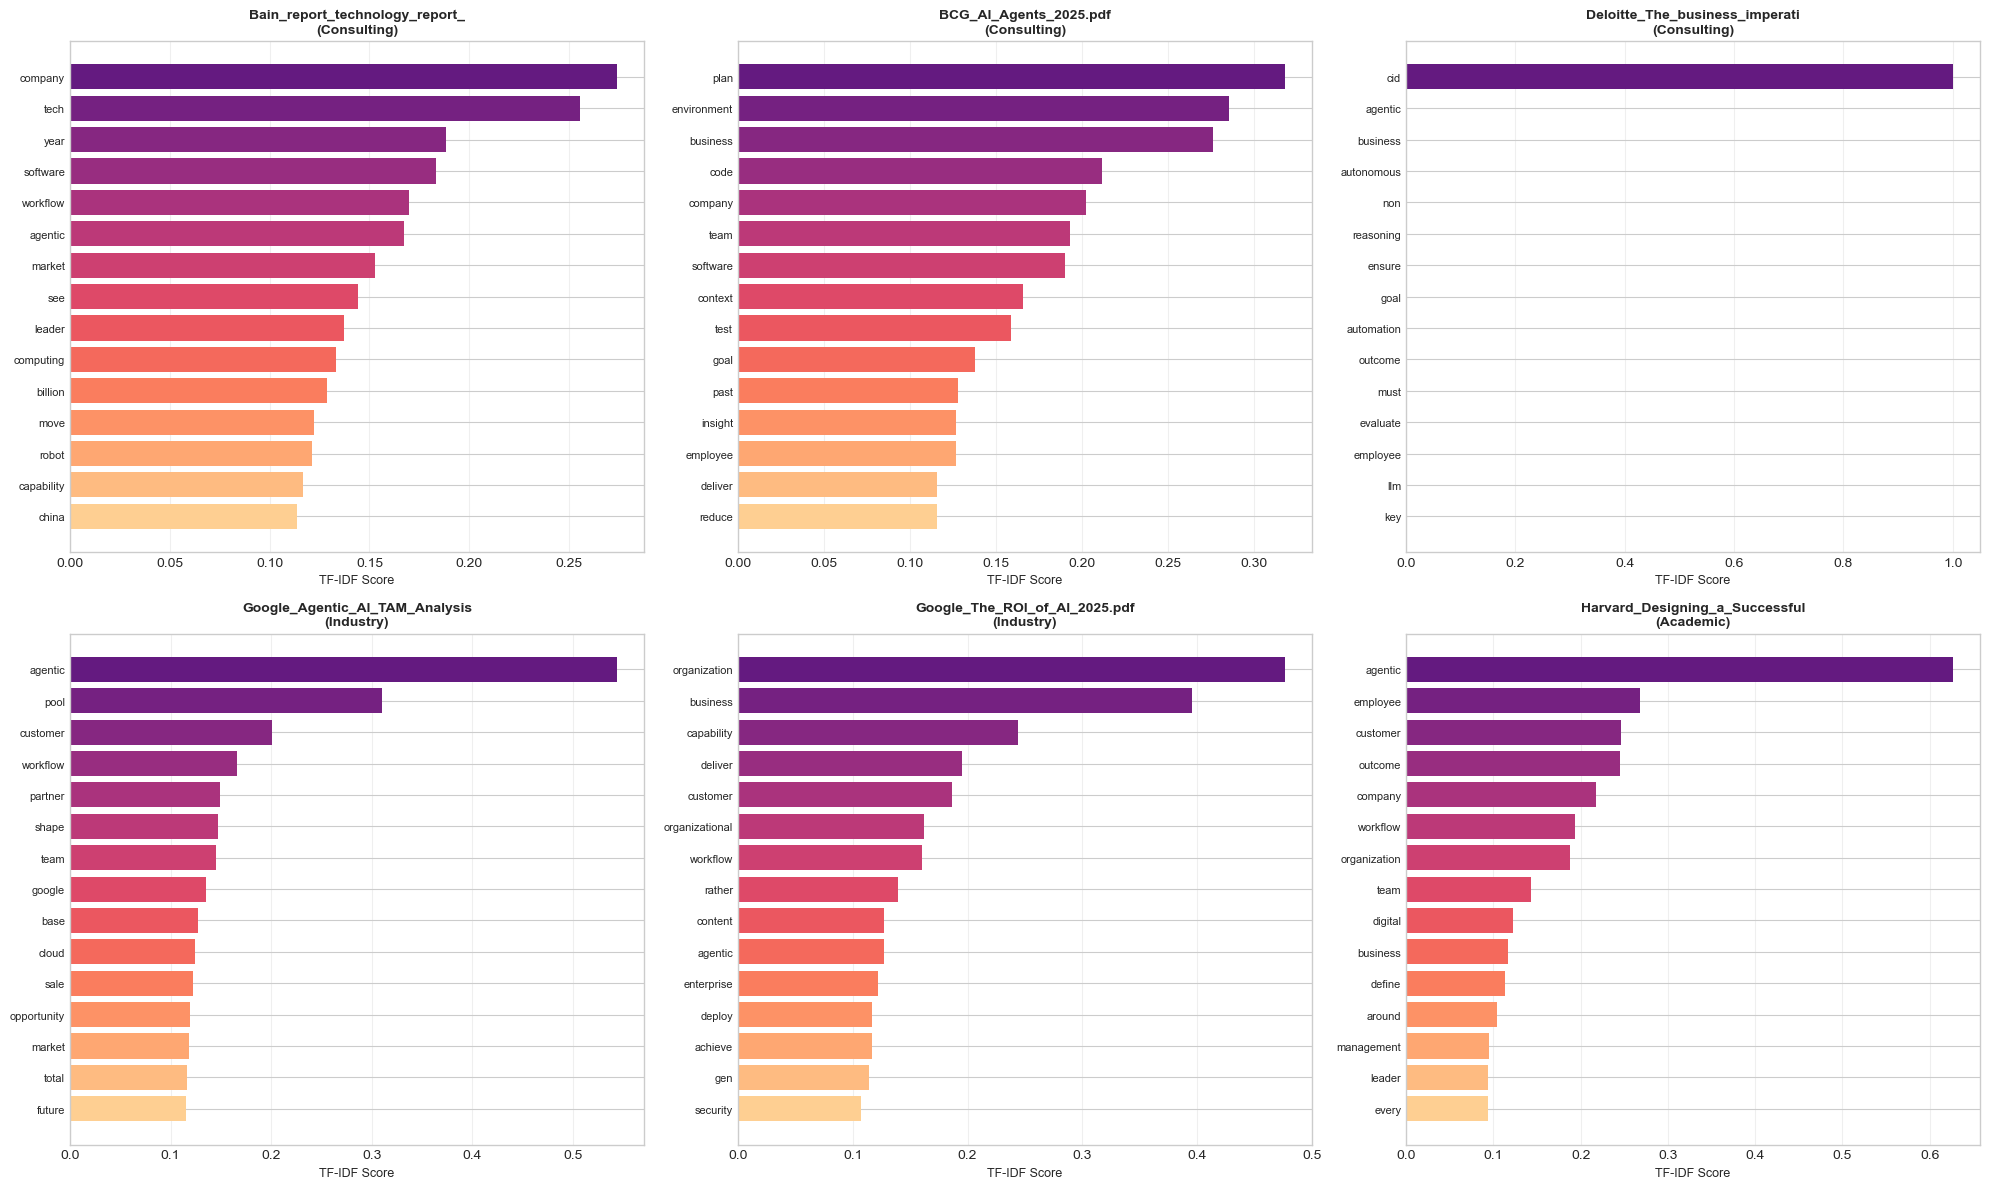

💾 Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\tfidf_top_terms_by_doc.png


In [34]:
n_docs_to_show = min(6, len(doc_ids_ordered))
docs_sample = doc_ids_ordered[:n_docs_to_show]

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, doc_id in enumerate(docs_sample):
    top_15 = list(top_terms_per_doc[doc_id].items())[:15]
    terms = [t[0] for t in top_15]
    scores = [t[1] for t in top_15]
    
    ax = axes[idx]
    colors = plt.cm.magma(np.linspace(0.3, 0.9, 15))
    ax.barh(range(15), scores, color=colors)
    ax.set_yticks(range(15))
    ax.set_yticklabels(terms, fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel('TF-IDF Score', fontsize=9)
    
    filename_short = metadata[doc_id]['filename'][:30]
    source_type = doc_to_source[doc_id]
    ax.set_title(f'{filename_short}\n({source_type})', fontsize=10, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

# (Optional) Delete empty axes if < 6 docs
for idx in range(n_docs_to_show, 6):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'tfidf_top_terms_by_doc.png', bbox_inches='tight')
plt.show()

print(f"💾 Graph saved to: {ANALYSIS_DIR / 'tfidf_top_terms_by_doc.png'}")

## 📊 Comparative analysis per source type

### Aggregation by source type (Consulting vs Academic vs Industry)

In [35]:
# Aggregate tokens per source type
tokens_by_source = defaultdict(list)

for doc_id, doc_data in processed_corpus.items():
    source_type = doc_to_source[doc_id]
    tokens_by_source[source_type].extend(doc_data['tokens'])

# Count frequencies by type
freq_by_source = {}
for source_type, tokens in tokens_by_source.items():
    freq_by_source[source_type] = Counter(tokens)
    total_tokens = len(tokens)
    vocab_size = len(freq_by_source[source_type])
    
    print(f"\n{source_type}:")
    print(f"  • Total tokens      : {total_tokens:,}")
    print(f"  • Unique vocabulary : {vocab_size:,}")
    print(f"  • Top 10 words:")
    
    for i, (word, count) in enumerate(freq_by_source[source_type].most_common(10), 1):
        print(f"    {i:2}. {word:20} : {count:5,}")


Consulting:
  • Total tokens      : 44,725
  • Unique vocabulary : 4,004
  • Top 10 words:
     1. cid                  : 16,850
     2. -                    :   816
     3. agent                :   506
     4. agentic              :   354
     5. technology           :   189
     6. datum                :   186
     7. company              :   181
     8. system               :   181
     9. model                :   165
    10. business             :   158

Industry:
  • Total tokens      : 32,532
  • Unique vocabulary : 7,204
  • Top 10 words:
     1. -                    : 1,055
     2. agent                :   786
     3. agentic              :   429
     4. system               :   427
     5. model                :   201
     6. value                :   171
     7. task                 :   167
     8. service              :   166
     9. user                 :   161
    10. customer             :   150

Academic:
  • Total tokens      : 78,842
  • Unique vocabulary : 8,511
  • T

### Top words by source type visual comparison

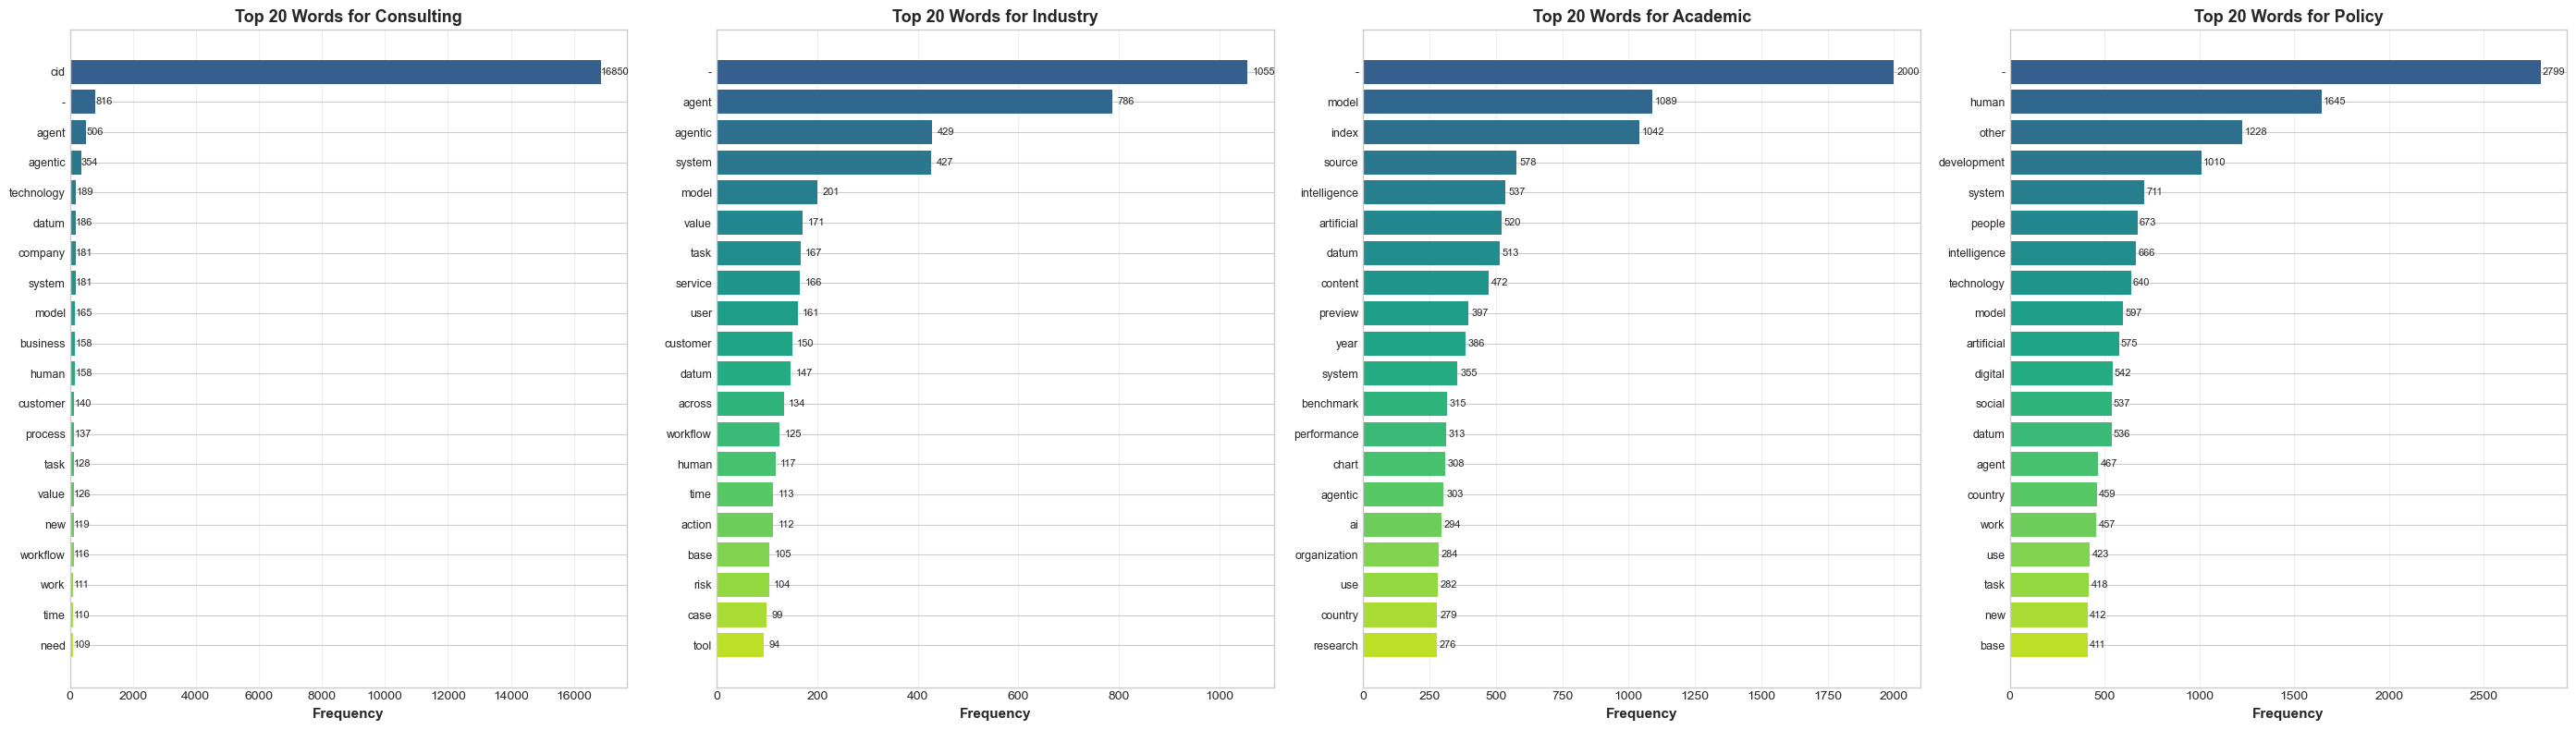

💾 Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\comparison_by_source_type.png


In [36]:
source_types = list(freq_by_source.keys())
n_sources = len(source_types)

fig, axes = plt.subplots(1, n_sources, figsize=(7*n_sources, 8))

if n_sources == 1:
    axes = [axes]

for idx, source_type in enumerate(source_types):
    top_20 = freq_by_source[source_type].most_common(20)
    words = [w for w, _ in top_20]
    counts = [c for _, c in top_20]
    
    ax = axes[idx]
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, 20))
    ax.barh(range(20), counts, color=colors)
    ax.set_yticks(range(20))
    ax.set_yticklabels(words, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(f'Top 20 Words for {source_type}', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    for i, count in enumerate(counts):
        ax.text(count + 10, i, str(count), va='center', fontsize=8)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'comparison_by_source_type.png', bbox_inches='tight')
plt.show()

print(f"💾 Graph saved to: {ANALYSIS_DIR / 'comparison_by_source_type.png'}")

### Distinctive terms by source type (TF-IDF inter-types)

In [37]:
# Create "documents" per type (via aggregation)
docs_by_type = []
types_ordered = []

for source_type, tokens in tokens_by_source.items():
    docs_by_type.append(' '.join(tokens))
    types_ordered.append(source_type)

# TF-IDF on types
tfidf_types = TfidfVectorizer(max_features=100, ngram_range=(1, 1))
tfidf_matrix_types = tfidf_types.fit_transform(docs_by_type)
feature_names_types = tfidf_types.get_feature_names_out()

# Extract top terms per type
print("\nTop 20 distinctive terms per type:\n")

for idx, source_type in enumerate(types_ordered):
    scores = tfidf_matrix_types[idx].toarray()[0]
    top_indices = scores.argsort()[-20:][::-1]
    
    print(f"{source_type}:")
    print("  " + "─"*65)
    
    for i, term_idx in enumerate(top_indices, 1):
        term = feature_names_types[term_idx]
        score = scores[term_idx]
        print(f"  {i:2}. {term:25} : {score:.4f}")
    print()


Top 20 distinctive terms per type:

Consulting:
  ─────────────────────────────────────────────────────────────────
   1. cid                       : 0.9993
   2. agent                     : 0.0199
   3. agentic                   : 0.0139
   4. technology                : 0.0074
   5. datum                     : 0.0073
   6. company                   : 0.0071
   7. system                    : 0.0071
   8. model                     : 0.0065
   9. human                     : 0.0062
  10. business                  : 0.0062
  11. customer                  : 0.0055
  12. process                   : 0.0054
  13. task                      : 0.0050
  14. value                     : 0.0049
  15. new                       : 0.0047
  16. work                      : 0.0044
  17. time                      : 0.0044
  18. need                      : 0.0043
  19. organization              : 0.0041
  20. service                   : 0.0040

Industry:
  ──────────────────────────────────────────────────

### WordClouds per source type

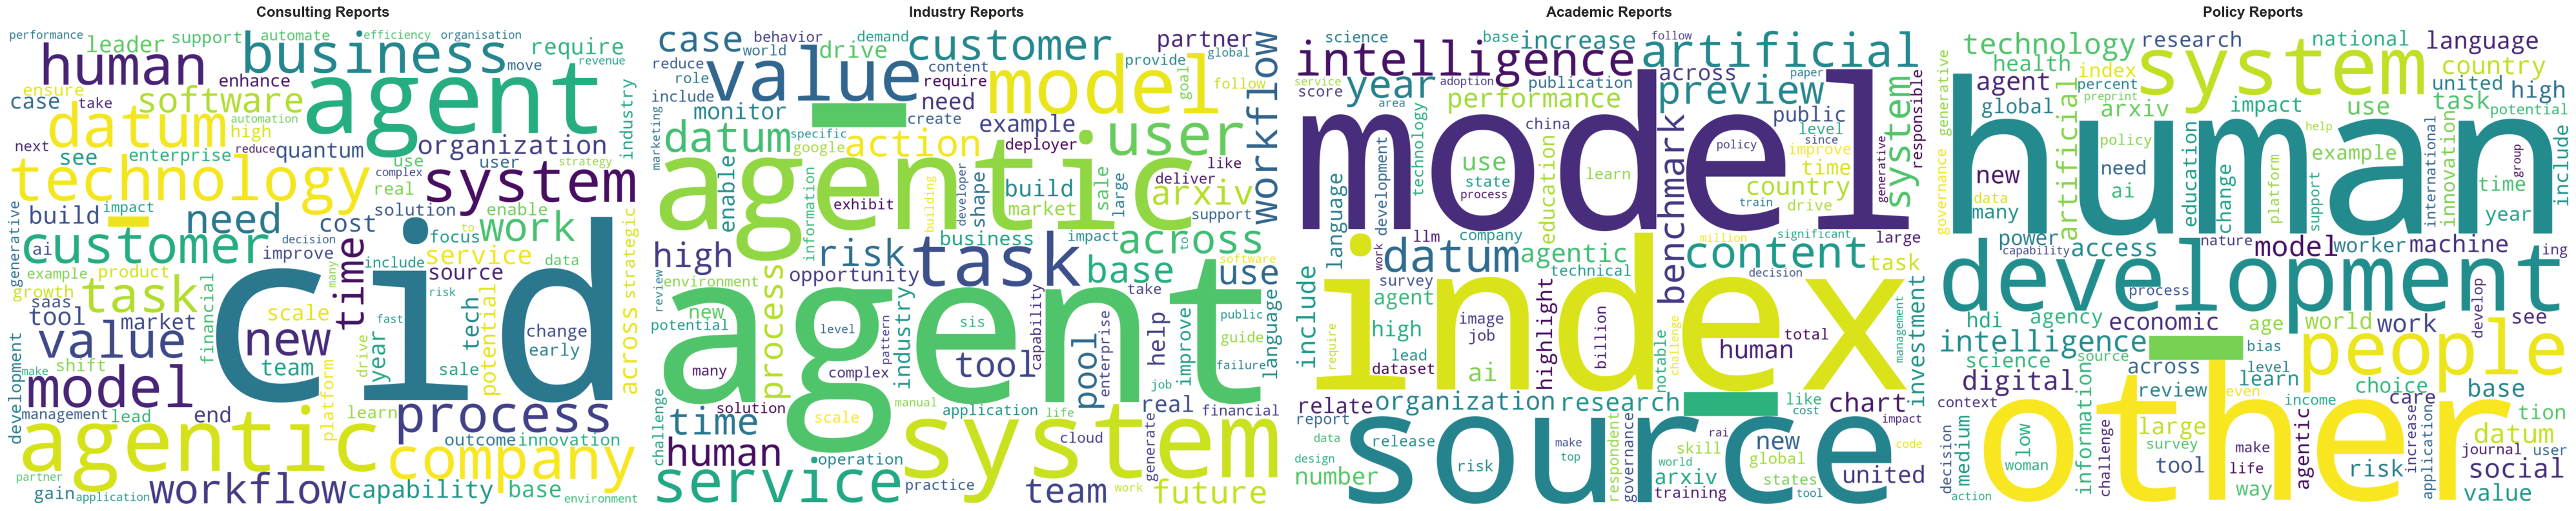

💾 WordClouds saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\wordclouds_by_source_type.png


In [38]:
# Create WordCloud for each type
n_sources = len(source_types)
fig, axes = plt.subplots(1, n_sources, figsize=(10*n_sources, 8))

if n_sources == 1:
    axes = [axes]

for idx, source_type in enumerate(source_types):
    # Generate WordCloud
    wordcloud = WordCloud(
        width=1600,
        height=1200,
        background_color='white',
        colormap='viridis',
        max_words=100,
        relative_scaling=0.5,
        collocations=False
    ).generate_from_frequencies(freq_by_source[source_type])
    
    ax = axes[idx]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'{source_type} Reports', fontsize=16, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'wordclouds_by_source_type.png', bbox_inches='tight')
plt.show()

print(f"💾 WordClouds saved to: {ANALYSIS_DIR / 'wordclouds_by_source_type.png'}")

### Key terms categories analysis per type

In [39]:
# Count terms by category for each type
category_by_source = defaultdict(lambda: defaultdict(int))

for source_type, tokens in tokens_by_source.items():
    token_freq = Counter(tokens)
    
    for category, terms in KEY_TERMS.items():
        for term in terms:
            category_by_source[source_type][category] += token_freq.get(term, 0)

# DataFrame for viz
data_cat_comparison = []
for source_type, categories in category_by_source.items():
    for category, count in categories.items():
        data_cat_comparison.append({
            'source_type': source_type,
            'category': category,
            'count': count
        })

df_cat_comparison = pd.DataFrame(data_cat_comparison)
df_cat_comparison

source_type        category  count
0   Consulting   Core Concepts    948
1   Consulting  Implementation    489
2   Consulting  Business Value    168
3   Consulting       Workforce    277
4   Consulting      Technology    160
5   Consulting      Governance    136
6   Consulting      Operations    434
7   Consulting      Assistance    118
8     Industry   Core Concepts   1258
9     Industry  Implementation    672
10    Industry  Business Value     89
11    Industry       Workforce    183
12    Industry      Technology     72
13    Industry      Governance    154
14    Industry      Operations    451
15    Industry      Assistance     81
16    Academic   Core Concepts   1108
17    Academic  Implementation   1592
18    Academic  Business Value    150
19    Academic       Workforce    731
20    Academic      Technology    455
21    Academic      Governance    451
22    Academic      Operations    424
23    Academic      Assistance    154
24      Policy   Core Concepts   1515
25      Policy  Implementation   1636
26      Policy  Business Value    292
27      Policy       Workforce   2269
28      Policy      Technology   1010
29      Policy      Governance    767
30      Policy      Operations    714
31      Policy      Assistance    335

In [40]:
print("\nOccurrences per category and type:\n")
pivot_table = df_cat_comparison.pivot(index='category', columns='source_type', values='count')
pivot_table = pivot_table.fillna(0).astype(int)
pivot_table


Occurrences per category and type:



source_type     Academic  Consulting  Industry  Policy
category                                              
Assistance           154         118        81     335
Business Value       150         168        89     292
Core Concepts       1108         948      1258    1515
Governance           451         136       154     767
Implementation      1592         489       672    1636
Operations           424         434       451     714
Technology           455         160        72    1010
Workforce            731         277       183    2269

### Category by type visualization

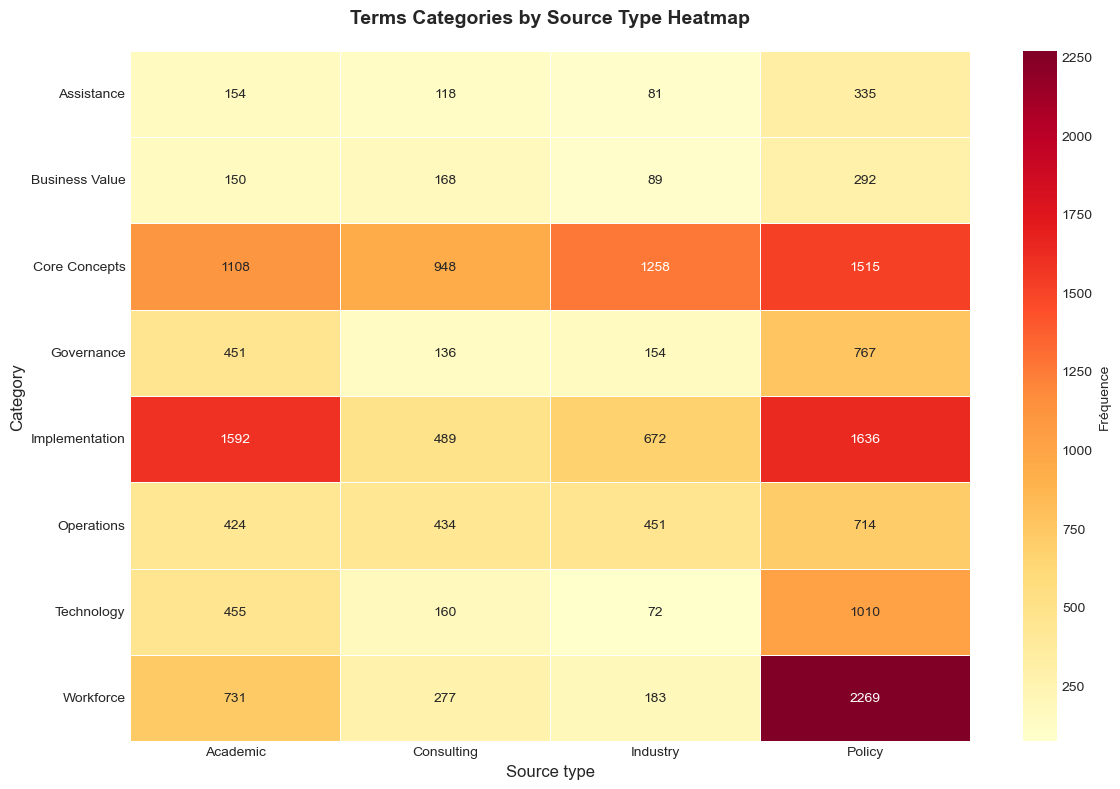

💾 Heatmap saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\heatmap_categories_by_source.png


In [41]:
# Category by type heatmap
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Fréquence'}, ax=ax)

ax.set_title('Terms Categories by Source Type Heatmap', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Source type', fontsize=12)
ax.set_ylabel('Category', fontsize=12)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'heatmap_categories_by_source.png', bbox_inches='tight')
plt.show()

print(f"💾 Heatmap saved to: {ANALYSIS_DIR / 'heatmap_categories_by_source.png'}")

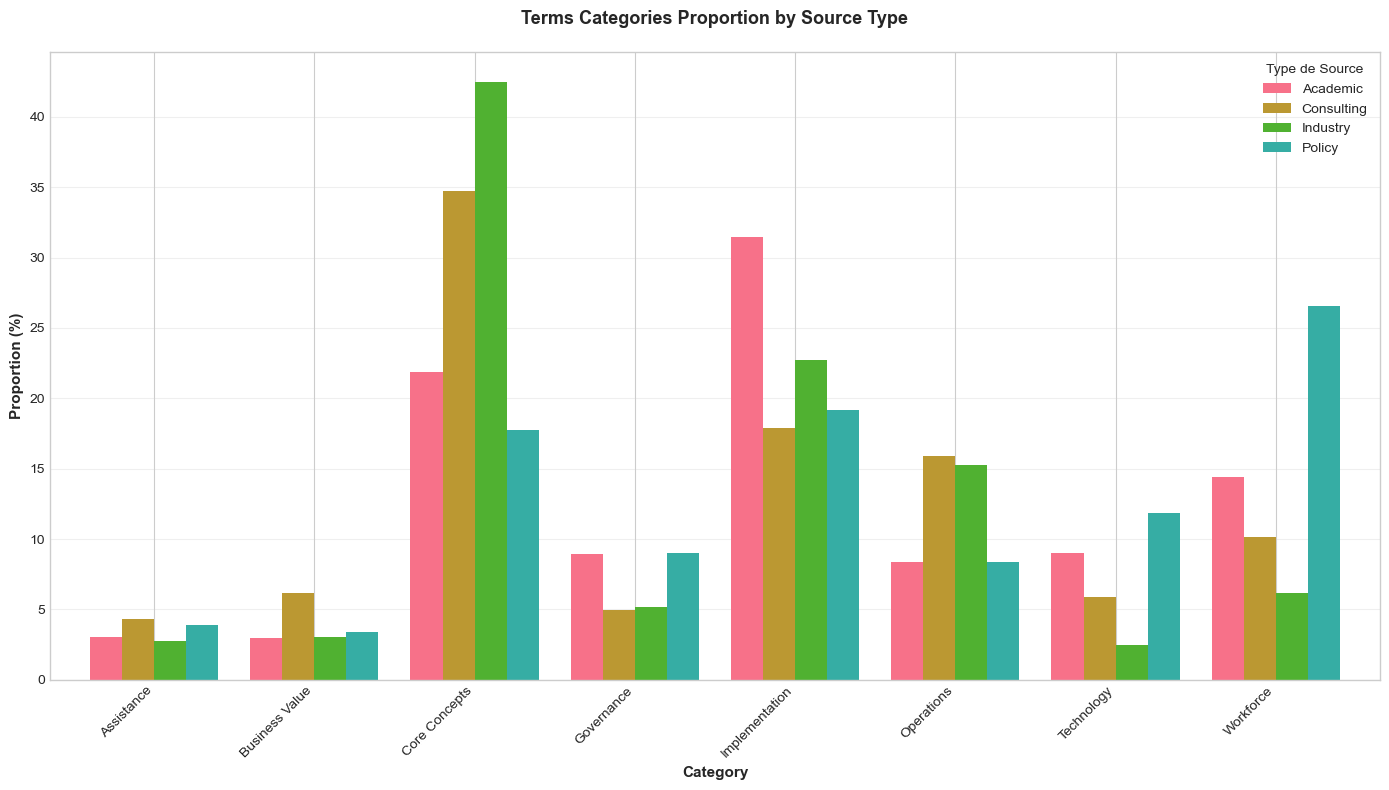

💾 Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\categories_proportion_by_source.png


In [42]:
# Graphique à barres groupées
pivot_table_pct = pivot_table.div(pivot_table.sum(axis=0), axis=1) * 100

fig, ax = plt.subplots(figsize=(14, 8))

pivot_table_pct.plot(kind='bar', ax=ax, width=0.8)

ax.set_ylabel('Proportion (%)', fontsize=11, fontweight='bold')
ax.set_xlabel('Category', fontsize=11, fontweight='bold')
ax.set_title('Terms Categories Proportion by Source Type', 
             fontsize=13, fontweight='bold', pad=20)
ax.legend(title='Type de Source', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'categories_proportion_by_source.png', bbox_inches='tight')
plt.show()

print(f"💾 Graph saved to: {ANALYSIS_DIR / 'categories_proportion_by_source.png'}")

## 💾 Save results

In [43]:
# Save global frequencies
df_global_freq = pd.DataFrame(
    global_freq.most_common(500),
    columns=['word', 'frequency']
)
df_global_freq.to_csv(ANALYSIS_DIR / 'global_word_frequencies.csv', index=False)
print(f"✅ Global frequencies: {ANALYSIS_DIR / 'global_word_frequencies.csv'}")

✅ Global frequencies: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\global_word_frequencies.csv


In [44]:
# Save TF-IDF top terms per doc
tfidf_results = []
for doc_id, terms_dict in top_terms_per_doc.items():
    filename = metadata[doc_id]['filename']
    source_type = doc_to_source[doc_id]
    
    for rank, (term, score) in enumerate(terms_dict.items(), 1):
        tfidf_results.append({
            'document_id': doc_id,
            'filename': filename,
            'source_type': source_type,
            'rank': rank,
            'term': term,
            'tfidf_score': score
        })

df_tfidf = pd.DataFrame(tfidf_results)
df_tfidf.to_csv(ANALYSIS_DIR / 'tfidf_top_terms_by_document.csv', index=False)
print(f"✅ TF-IDF par document: {ANALYSIS_DIR / 'tfidf_top_terms_by_document.csv'}")

✅ TF-IDF par document: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\tfidf_top_terms_by_document.csv


In [45]:
# Save bigrams and trigrams
df_bigrams = pd.DataFrame(
    [(' '.join(bg), count) for bg, count in bigram_freq.most_common(100)],
    columns=['bigram', 'frequency']
)
df_bigrams.to_csv(ANALYSIS_DIR / 'top_bigrams.csv', index=False)
print(f"✅ Top bigrams: {ANALYSIS_DIR / 'top_bigrams.csv'}")

df_trigrams = pd.DataFrame(
    [(' '.join(tg), count) for tg, count in trigram_freq.most_common(100)],
    columns=['trigram', 'frequency']
)
df_trigrams.to_csv(ANALYSIS_DIR / 'top_trigrams.csv', index=False)
print(f"✅ Top trigrams: {ANALYSIS_DIR / 'top_trigrams.csv'}")

✅ Top bigrams: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\top_bigrams.csv
✅ Top trigrams: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\top_trigrams.csv


In [46]:
# Save co-occurrences
for target, cooccur in cooccurrence_results.items():
    df_cooccur = pd.DataFrame(
        cooccur.most_common(50),
        columns=['cooccurring_word', 'frequency']
    )
    df_cooccur['target_word'] = target
    df_cooccur.to_csv(ANALYSIS_DIR / f'cooccurrences_{target}.csv', index=False)

print(f"✅ Co-occurrences save for: {', '.join(TARGET_WORDS)}")

✅ Co-occurrences save for: agent, agentic, autonomy, autonomous, ai


In [47]:
# Save comparaison per type
df_cat_comparison.to_csv(ANALYSIS_DIR / 'categories_by_source_type.csv', index=False)
print(f"✅ Categories by type: {ANALYSIS_DIR / 'categories_by_source_type.csv'}")

✅ Categories by type: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\categories_by_source_type.csv


In [48]:
# Save detailed key terms
df_key_terms.to_csv(ANALYSIS_DIR / 'key_terms_frequencies.csv', index=False)
print(f"✅ Key terms: {ANALYSIS_DIR / 'key_terms_frequencies.csv'}")

✅ Key terms: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis\key_terms_frequencies.csv


## 📊 Insights summary for report use

In [49]:
# Insight 1: Most frequent words
print("\n🔹 TOP 10 GLOBAL WORDS:")
for word, count in global_freq.most_common(10):
    print(f"   • {word:15} : {count:,} occurrences")

# Insight 2: Dominant categories
print("\n🔹 DOMINANT CATEGORIES:")
for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"   • {category:20} : {count:,} occurrences")

# Insight 3: Key bigrams
print("\n🔹 TOP 5 SIGNIFICATIVE BIGRAMS:")
for bigram in top_bigrams_pmi[:5]:
    bigram_str = ' '.join(bigram)
    count = bigram_freq[bigram]
    print(f"   • {bigram_str:30} : {count:,} occurrences")

# Insight 4: Differences per type
print("\n🔹 EMPHASIS PER SOURCE TYPE:")
for source_type in source_types:
    top_3 = freq_by_source[source_type].most_common(3)
    words_str = ', '.join([w for w, _ in top_3])
    print(f"   • {source_type:15} : {words_str}")

# Insight 5: Co-occurrences with "agent"
print("\n🔹 TOP 5 CO-OCCURRENCES WITH 'AGENT':")
for word, count in cooccurrence_results['agent'].most_common(5):
    print(f"   • {word:20} : {count:,}")


🔹 TOP 10 GLOBAL WORDS:
   • cid             : 16,851 occurrences
   • -               : 6,670 occurrences
   • human           : 2,193 occurrences
   • model           : 2,052 occurrences
   • agent           : 1,947 occurrences
   • system          : 1,674 occurrences
   • datum           : 1,382 occurrences
   • agentic         : 1,322 occurrences
   • development     : 1,280 occurrences
   • other           : 1,271 occurrences

🔹 DOMINANT CATEGORIES:
   • Core Concepts        : 4,829 occurrences
   • Implementation       : 4,389 occurrences
   • Workforce            : 3,460 occurrences
   • Operations           : 2,023 occurrences
   • Technology           : 1,697 occurrences

🔹 TOP 5 SIGNIFICATIVE BIGRAMS:
   • acir atsoc                     : 5 occurrences
   • atsushi kanehira               : 5 occurrences
   • dhar thuppilikkat              : 5 occurrences
   • lari hämäläinen                : 5 occurrences
   • njenga kariuki                 : 5 occurrences

🔹 EMPHASIS PER SOU

## 📋 Step 3 summary

**✅ Analyses complétées:**
- Fréquences globales et par document
- Termes clés spécifiques au domaine (8 catégories)
- Co-occurrences autour des termes principaux
- N-grams (bigrams et trigrams)
- TF-IDF (termes distinctifs par document)
- Analyse comparative par type de source

**📂 Fichiers générés:**
- 12+ graphiques PNG haute résolution
- 8 fichiers CSV avec données détaillées
- Tous dans `data/processed/analysis/`

**📊 Visuels pour le rapport:**
1. `top30_global_frequencies.png` - Fréquences globales
2. `wordcloud_global.png` - Vue d'ensemble du vocabulaire
3. `key_terms_categories.png` - Catégories de termes
4. `cooccurrences_main_terms.png` - Co-occurrences
5. `top25_bigrams.png` - Bigrams fréquents
6. `tfidf_top_terms_by_doc.png` - Spécificités par document
7. `comparison_by_source_type.png` - Comparaison par type
8. `heatmap_categories_by_source.png` - Catégories par type

**➡️ Prochaine étape:**
- Étape 4: Topic Modeling (LDA) pour identifier les thèmes dominants

In [50]:
# Summary Step 3
print("STEP 3 FINISHED SUCCESSFULLY!")
print(f"\n📊 Analysis summary:")
print(f"  • Analyzed vocabulary      : {vocab_size:,} mots uniques")
print(f"  • Identified Bigrams       : {len(bigram_freq):,}")
print(f"  • Identified Trigrams      : {len(trigram_freq):,}")
print(f"  • TF-IDF Documents         : {len(processed_corpus)}")
print(f"  • Sources Types            : {len(source_types)}")
print(f"\n📂 All files saved to: {ANALYSIS_DIR}")
print(f"\n➡️ Ready for Step 4: Topic Modeling (LDA)\n")

STEP 3 FINISHED SUCCESSFULLY!

📊 Analysis summary:
  • Analyzed vocabulary      : 17,083 mots uniques
  • Identified Bigrams       : 190,817
  • Identified Trigrams      : 245,256
  • TF-IDF Documents         : 21
  • Sources Types            : 4

📂 All files saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\analysis

➡️ Ready for Step 4: Topic Modeling (LDA)

